In [95]:
import pandas as pd
import pandas.io.sql as sqlio
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5, style="whitegrid")
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import numpy as np
from connector import getConnection

### Mean  index rate (monthly basis)

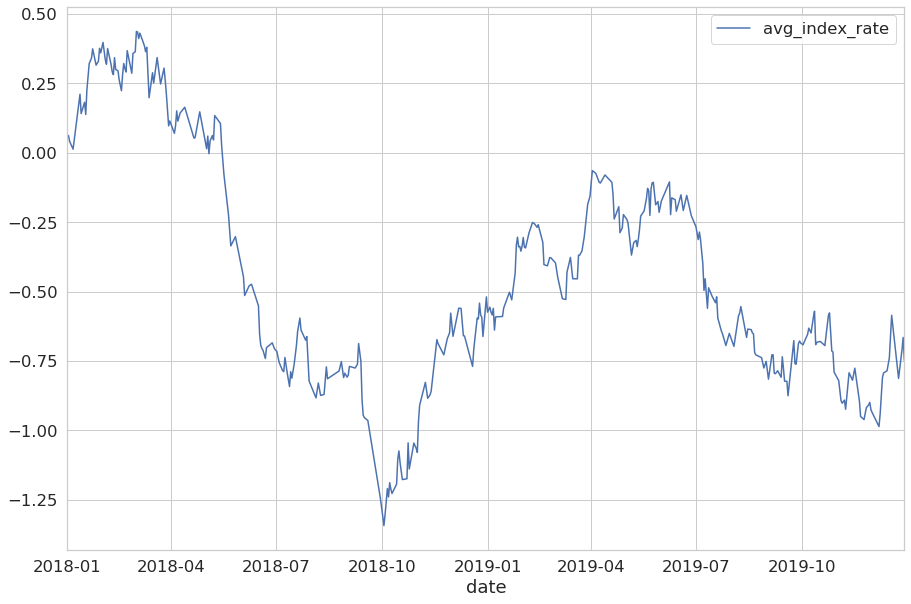

In [83]:
conn = getConnection()

sql = """
SELECT d.date ,AVG(s.index_rate) as avg_index_rate  FROM sale s, date d
WHERE s.sale_date_key = d.date_key 
GROUP BY d.date
HAVING AVG(s.index_rate) IS NOT NULL
ORDER BY d.date
"""

df = sqlio.read_sql_query(sql, conn)


conn.close()
df.head()
df.plot(kind='line',x='date',y='avg_index_rate',figsize=(15,10))



### distribution of loans on maritial status

marital_status,divorced,married,single
loan_amount,4548500.0,22495500.0,10891000.0


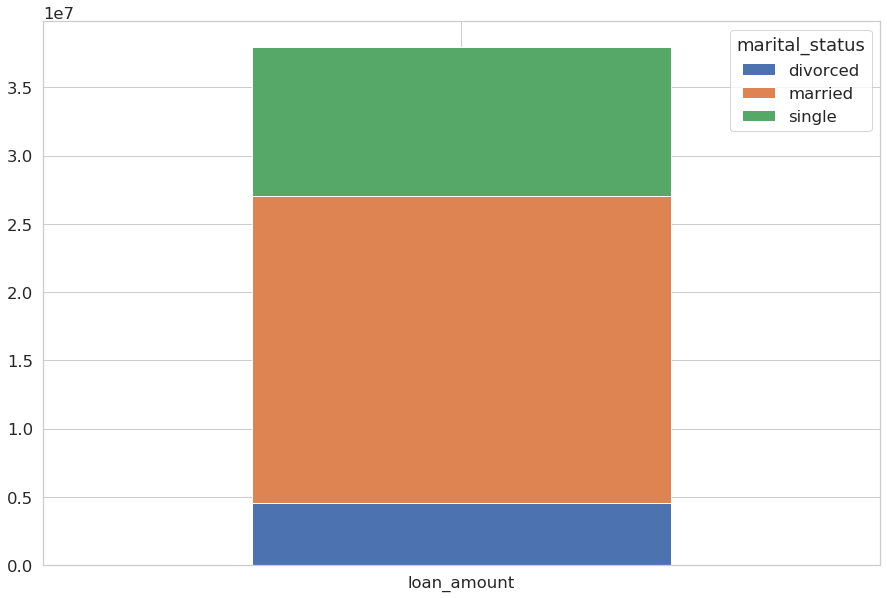

In [84]:
conn = getConnection()

sql = """
SELECT c.marital_status , SUM(s.loan_amount) as loan_amount  FROM sale s, customer c
WHERE s.customer_key = c.customer_key
GROUP BY c.marital_status
"""

df = sqlio.read_sql_query(sql, conn)

df = df.set_index('marital_status')
df = df.transpose()

df.plot.bar(stacked=True,figsize=(15,10), rot = 0)
conn.close()
df.head()



### Distribution of loans by age

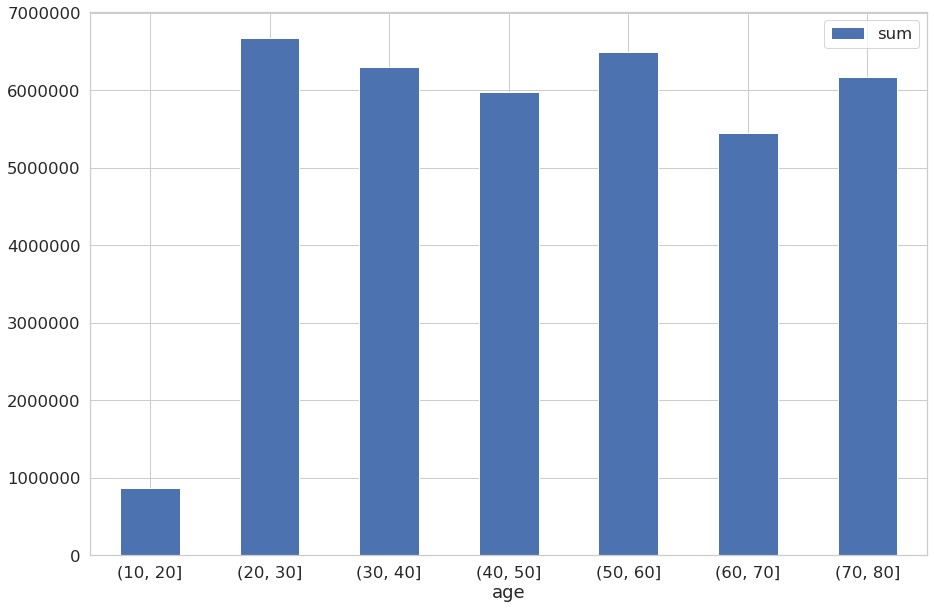

In [139]:
conn = getConnection()

sql = """
SELECT (2020 - c.birth_year) as age ,SUM( s.loan_amount)as loan_amount
FROM sale s, customer c
WHERE s.customer_key = c.customer_key
GROUP BY AGE
"""

df = sqlio.read_sql_query(sql, conn)
bins = pd.cut(df['age'], [10, 20, 30,40,50,60,70,80])
df = df.groupby(bins)['loan_amount'].agg(['sum'])
conn.close()
df.head()
df.plot.bar(figsize=(15,10), rot = 0)



### Distribution by job

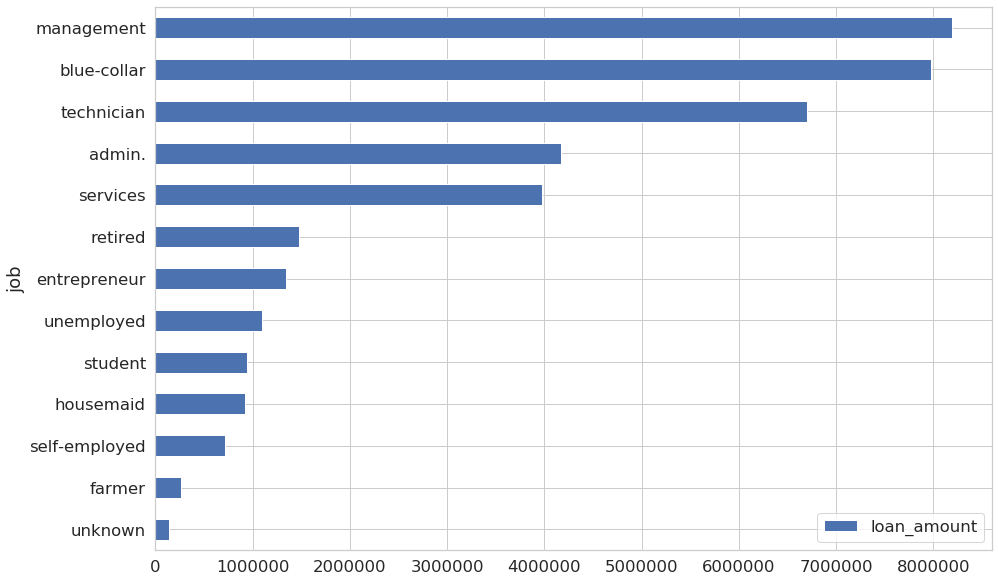

In [143]:
conn = getConnection()

sql = """
SELECT c.job ,SUM( s.loan_amount)as loan_amount
FROM sale s, customer c
WHERE s.customer_key = c.customer_key
GROUP BY c.job
ORDER BY loan_amount
"""

df = sqlio.read_sql_query(sql, conn)
#bins = pd.cut(df['age'], [0, 20, 40, 60,80])
#df = df.groupby(bins)['loan_amount'].agg(['sum'])
df = df.set_index('job')
conn.close()
df.head()
df.plot.barh(figsize=(15,10), rot = 0)